# Arctic Carbon: Map Plots

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import matplotlib.cm as cm

from tqdm import tqdm

import cartopy as ca
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator)

In [2]:
datapath = "/work/uo1227/u301557/ArcticCarbon/data/2D/"

In [3]:
def load_data(variable, model, region, scenario):
    file = glob.glob(f"{datapath}{variable}/{variable}_{region}_{model}_*_{scenario}.nc")[0]#
    ds = xr.open_dataset(file)
    return ds

def calc_20_yr_mean(ds, variable):
    last_time_index = ds.time.size
    twenty_years_back_index = last_time_index - 20   
    last_20_yrs = ds[variable].isel(time=slice(twenty_years_back_index,last_time_index,1)).mean(dim="time")
    return last_20_yrs

def plot_map(ds, last_20_yrs, cbar_label="", vmax=None, vmin=None, cmap_str="viridis", under=None, fig=None, ax=None):
                                   # define extent you want to plot (see below)
    projection = ccrs.NorthPolarStereo()
    
    data_crs  = ccrs.PlateCarree()                                # on which projection is your data on?

    if fig is None or ax is None:
        fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(8,6), subplot_kw={'projection': projection}, constrained_layout=True)
        
    cmap = cm.get_cmap(cmap_str).copy()
    if under is not None:
        cmap.set_under(under)
    im = ax.pcolormesh(ds.lon, ds.lat, last_20_yrs, transform = data_crs, cmap = cmap, vmax=vmax, vmin=vmin)#*1e5
    
    ax.coastlines()                                                 # add coastlines

    ocean_vars = ["fgco2", "froc", "fric", "intpp", "intpoc", "intdic", "intdoc", "ocfriver"]
    land_vars  = ["cSoil", "cVeg", "fLuc", "gpp", "nbp", "nep", "npp", "ra", "rh"]

    if variable in ocean_vars:
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='black', facecolor='grey') # color land & add coast line
        extend    = [-180, 180, 66, 90]
    else:
        extend    = [-180, 180, 50, 90]
    ax.set_extent(extend, crs = data_crs)                          # set the extent you want to plot
    
    fig.colorbar(im, ax=ax, extend="both",fraction=0.05, pad=0.04, label=cbar_label)
    return fig, ax


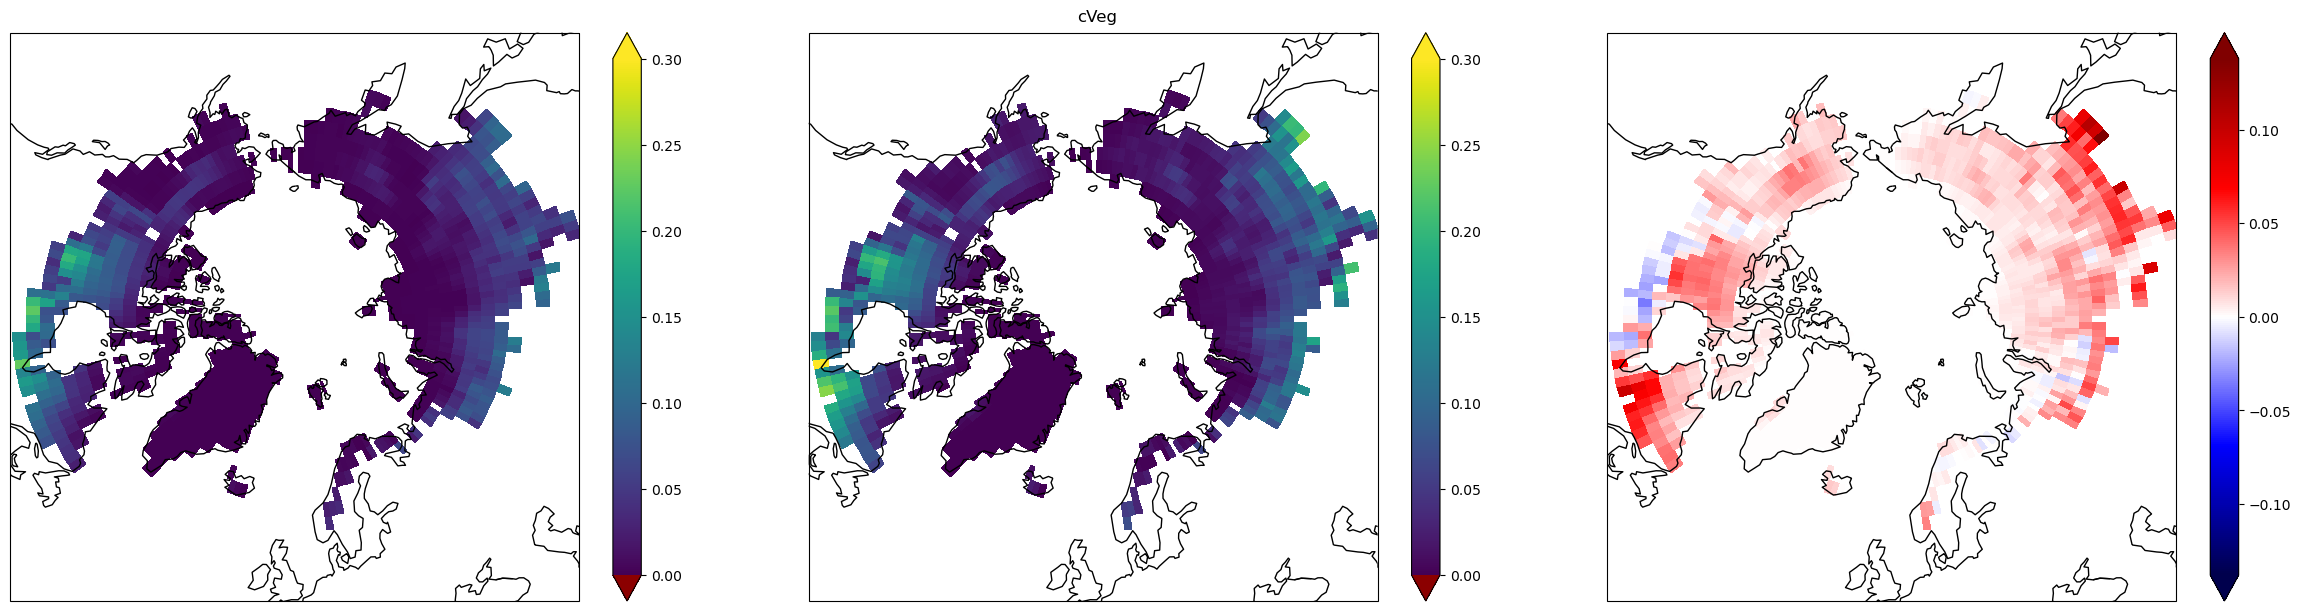

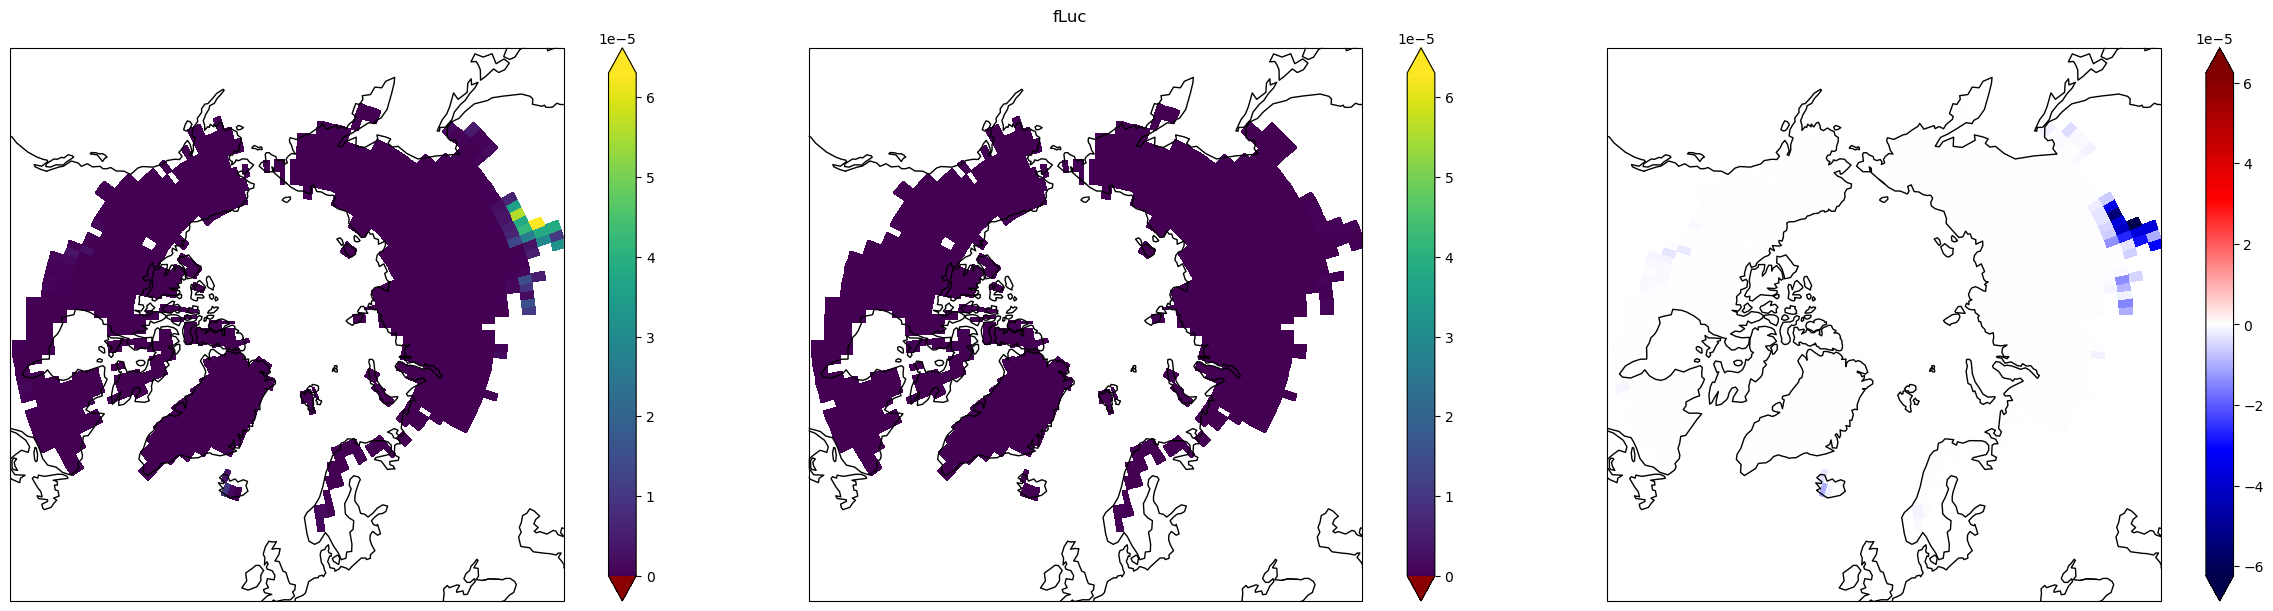

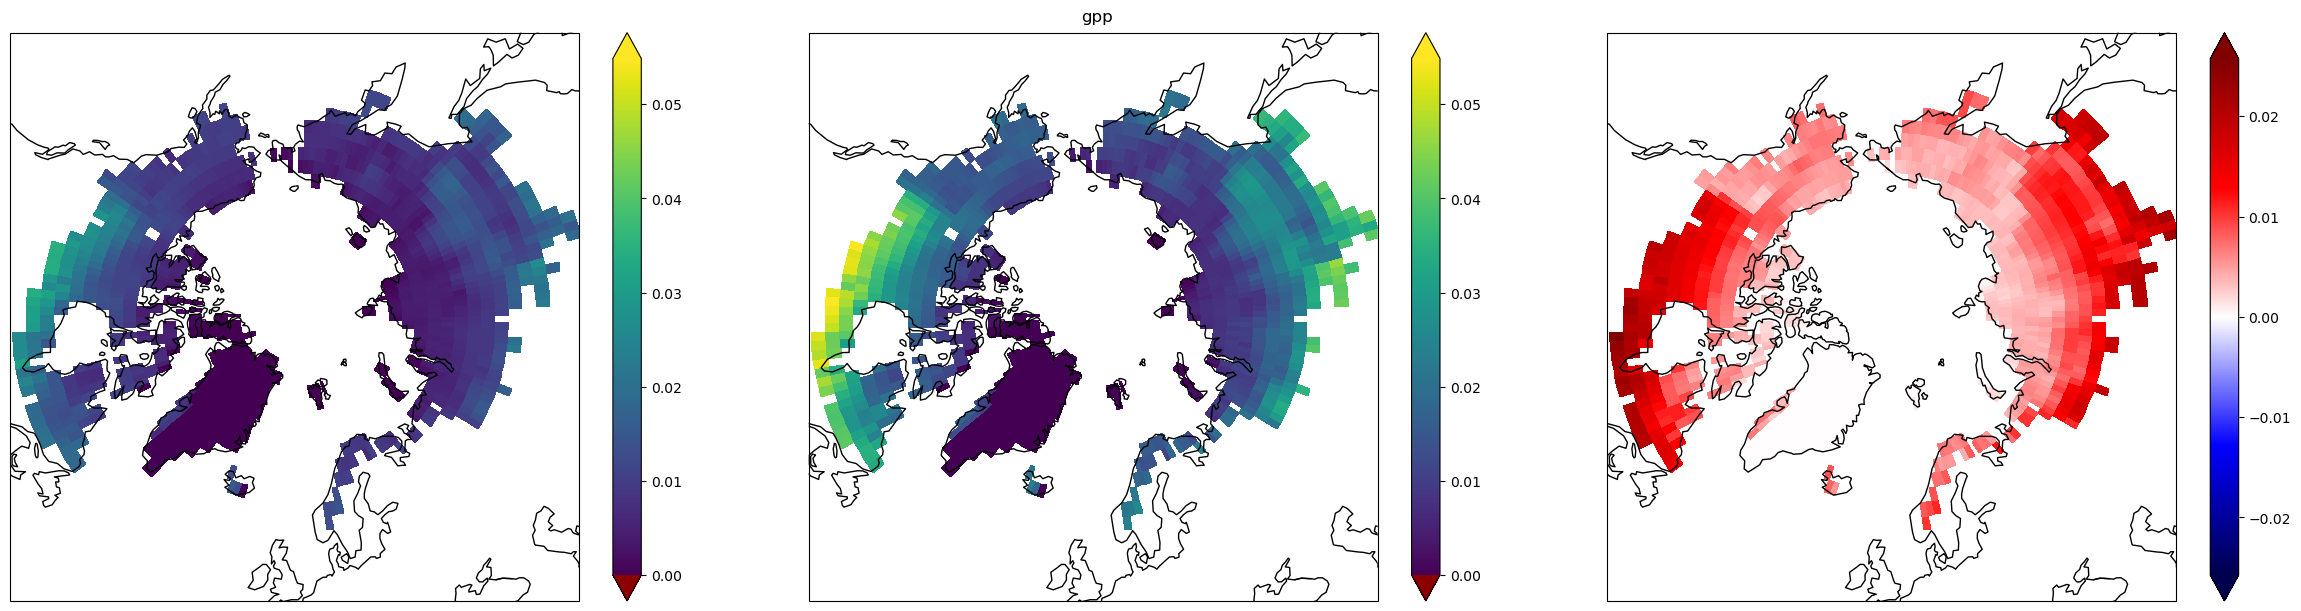

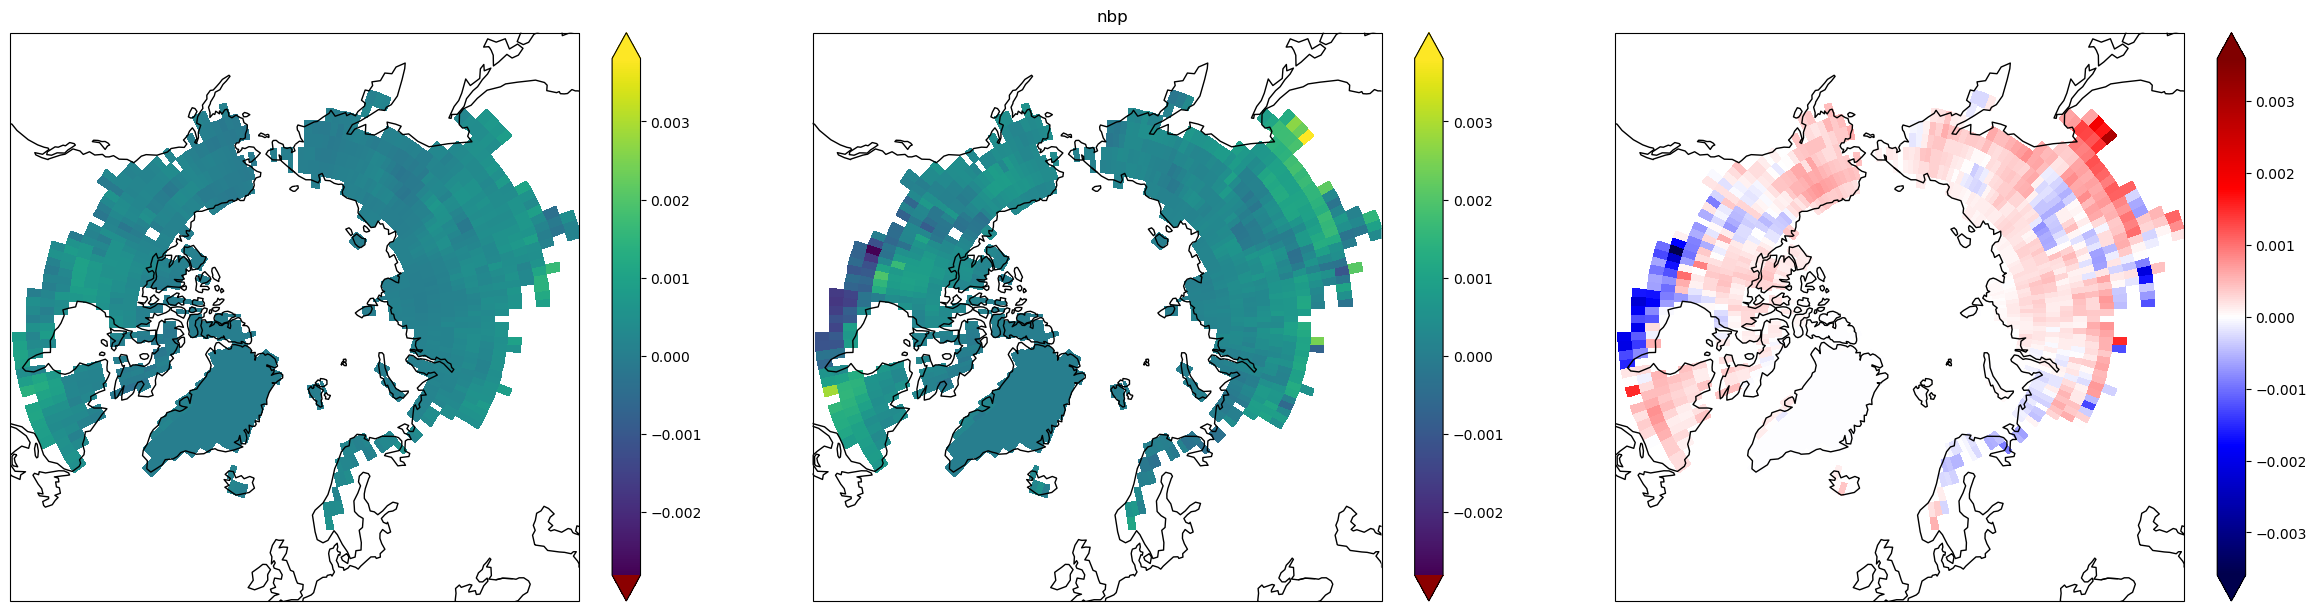

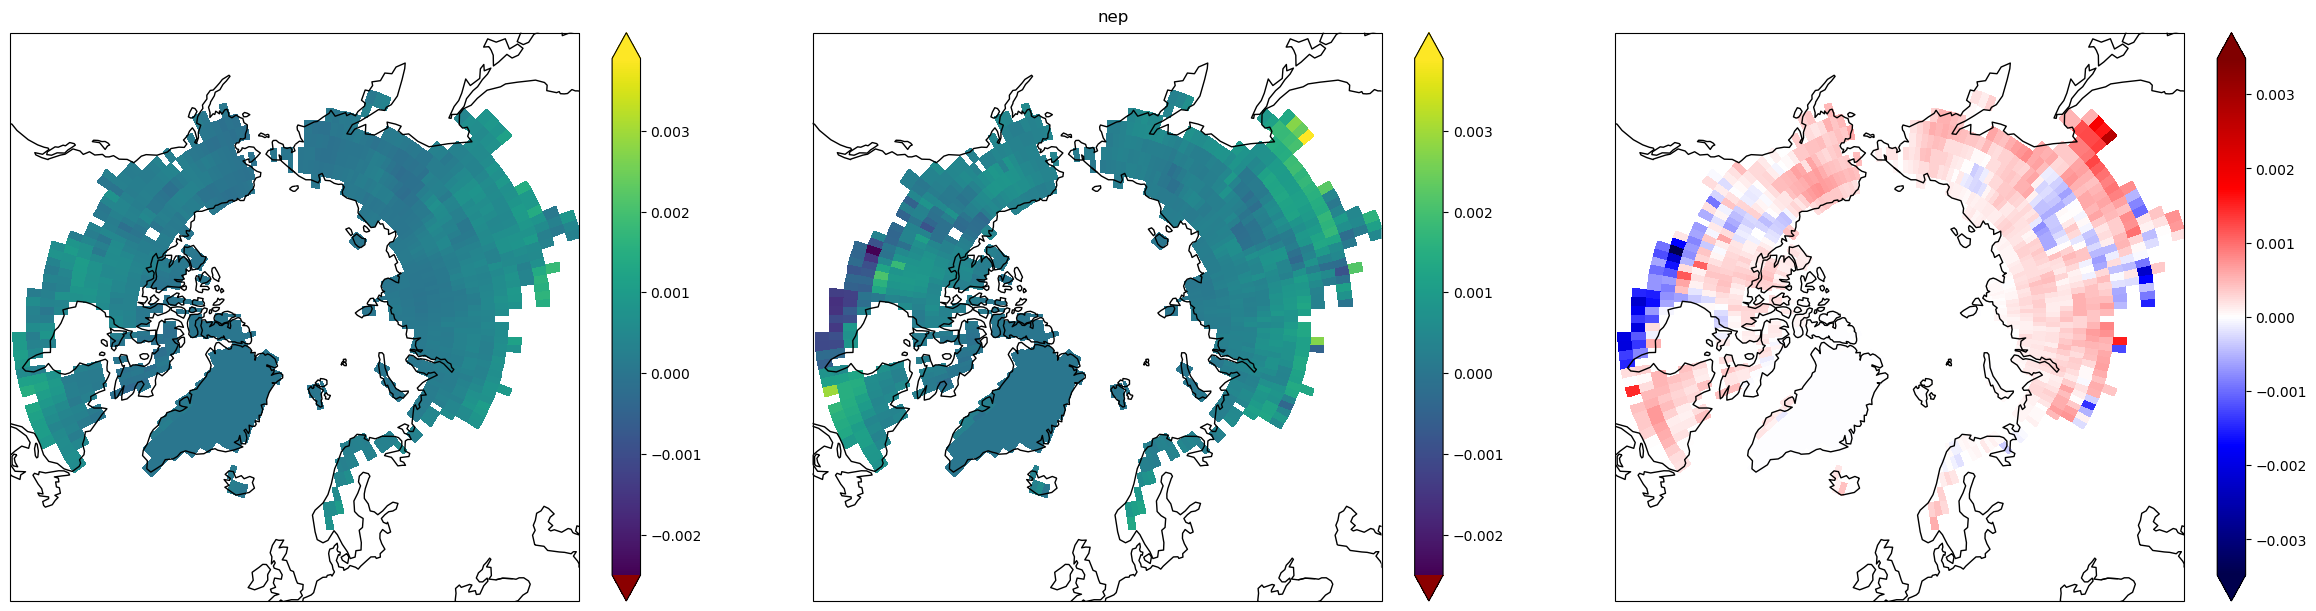

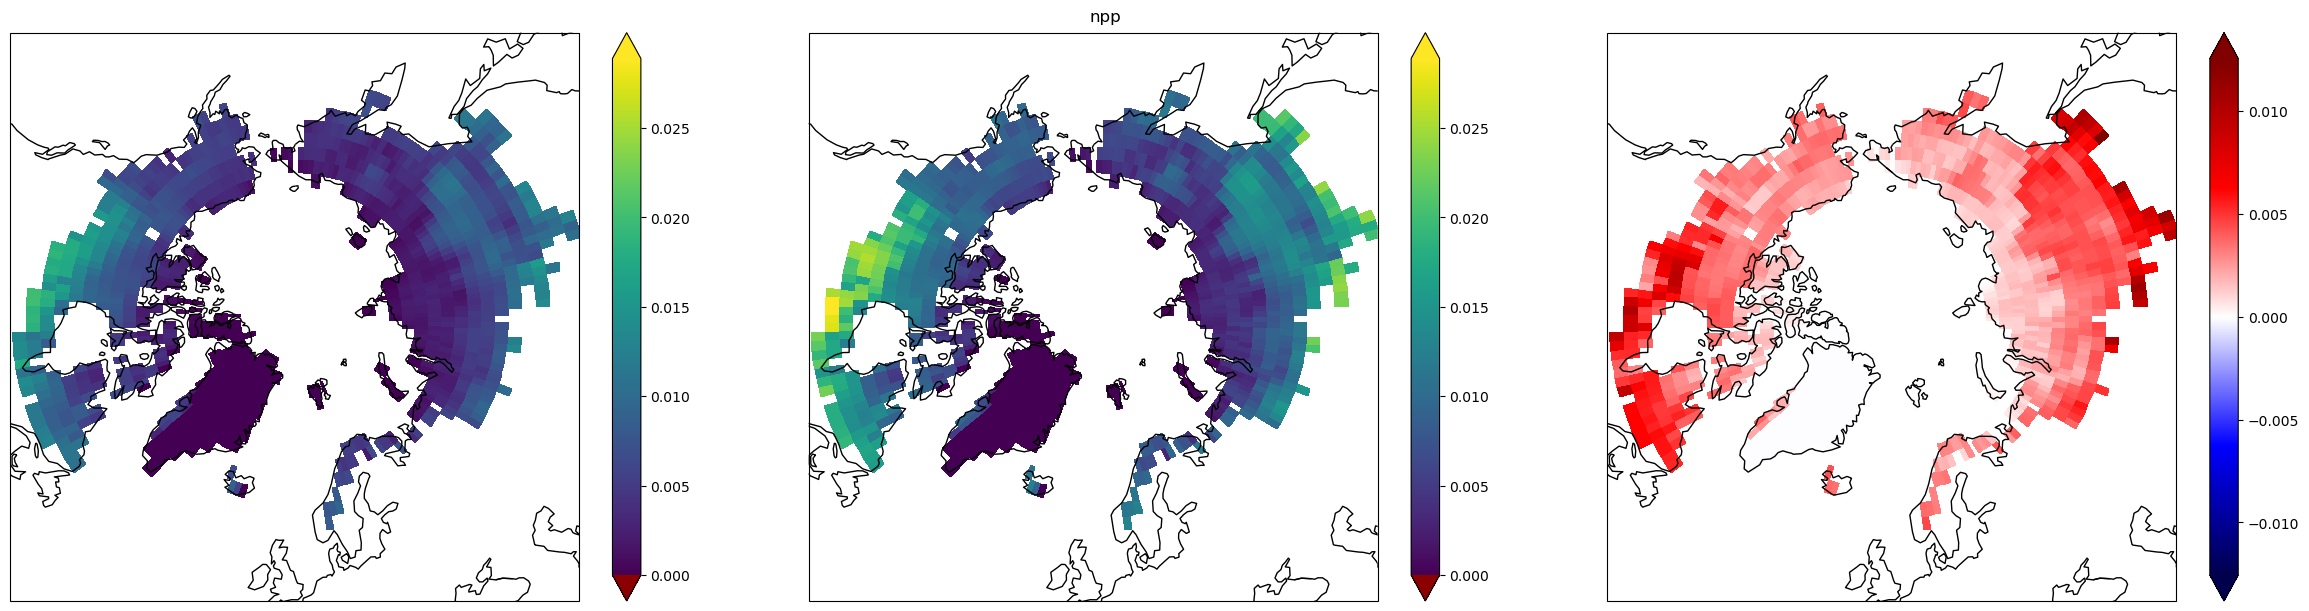

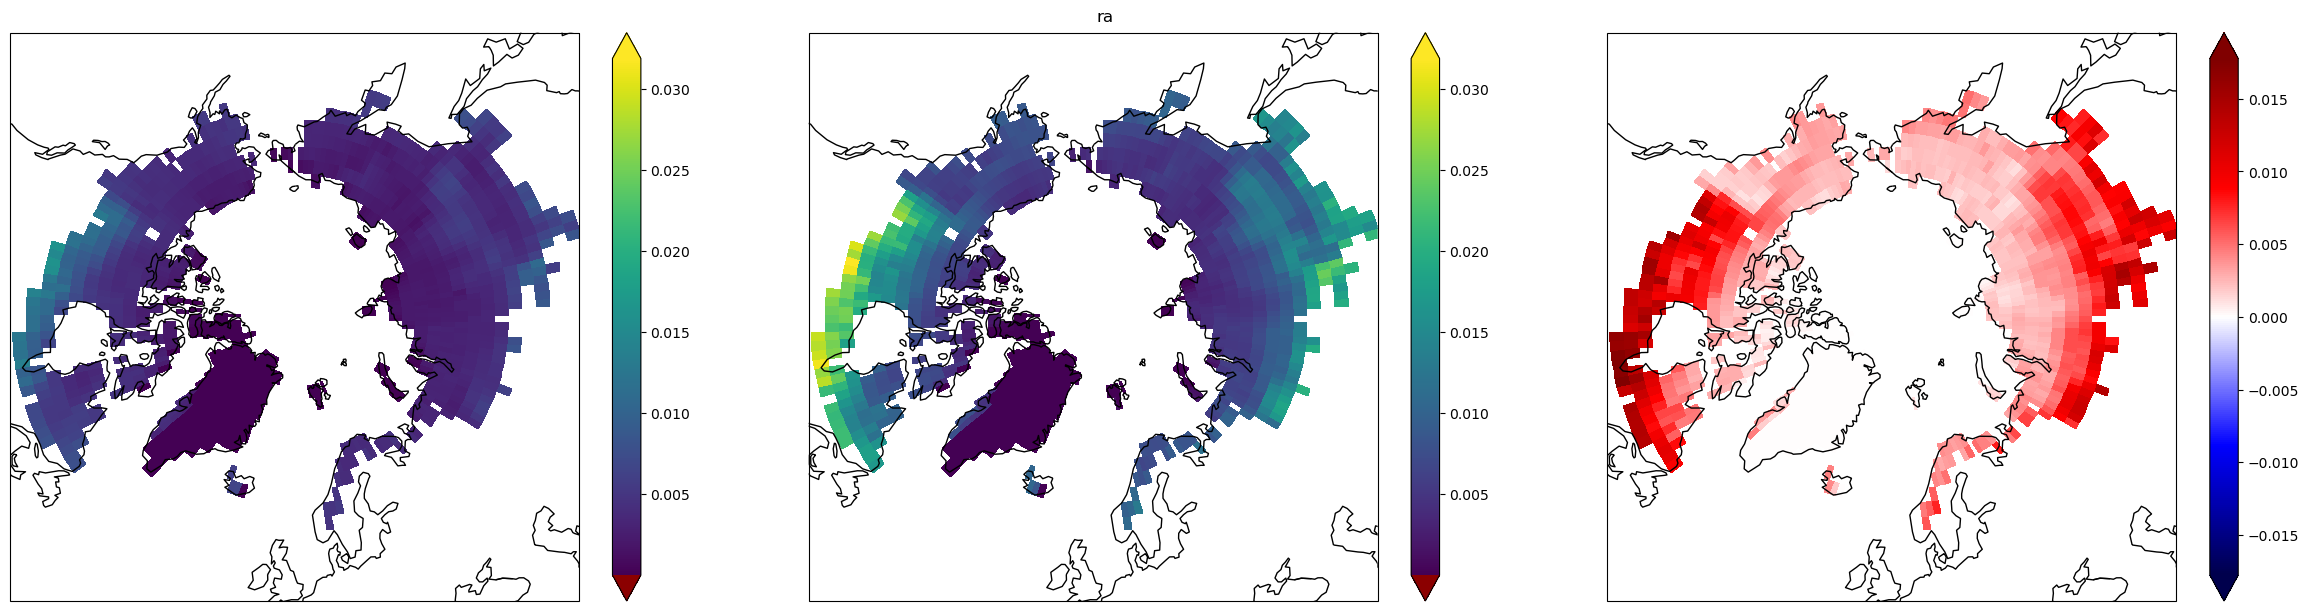

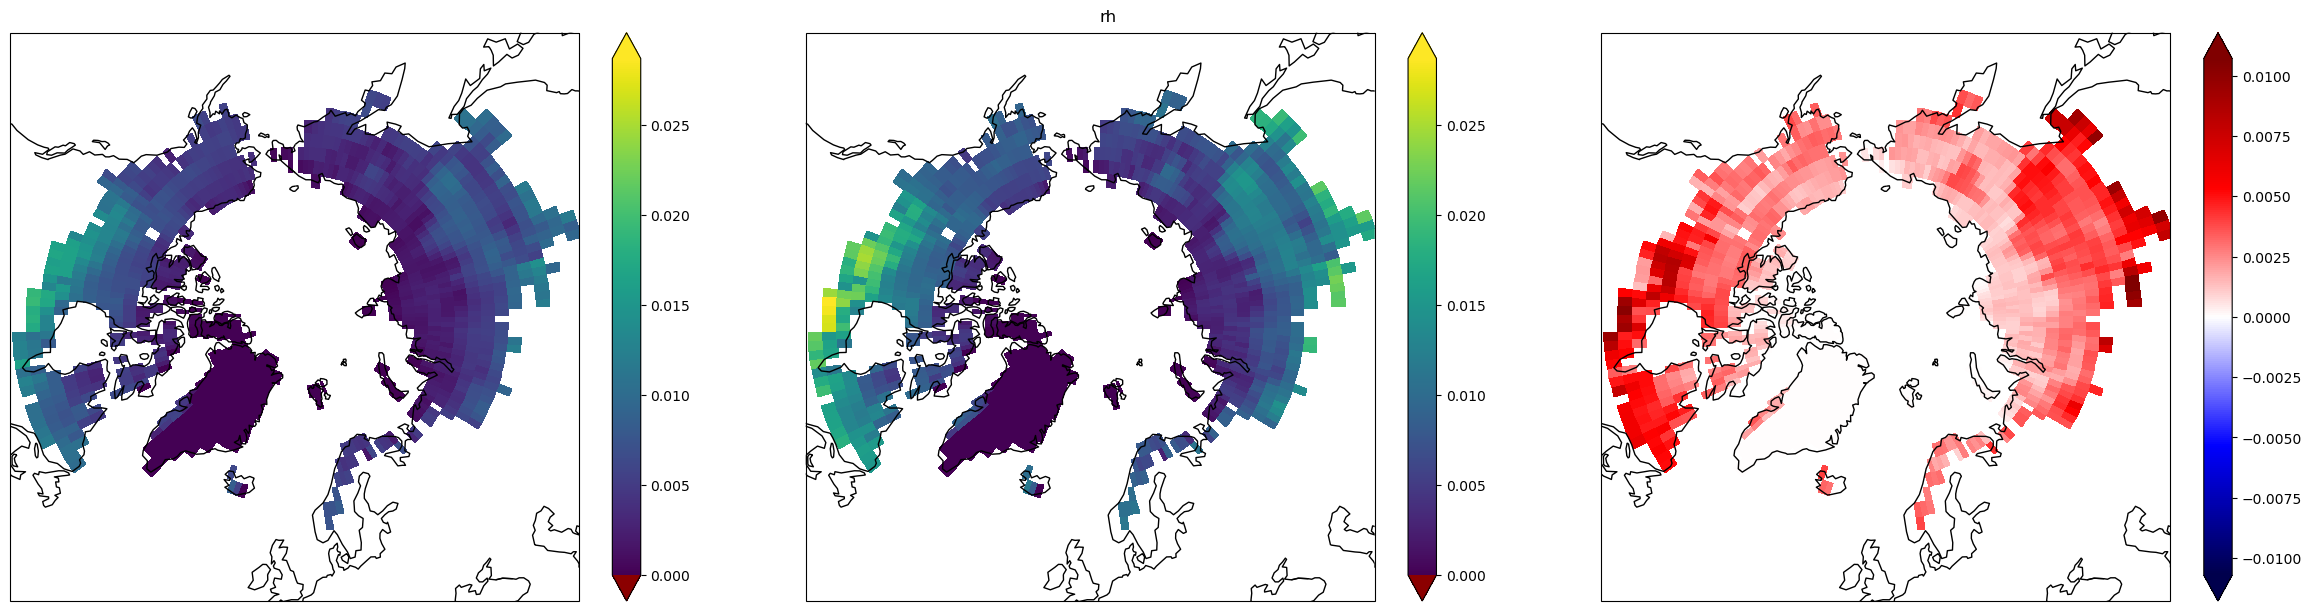

In [118]:
variables = ["fgco2", "intpp", "intpoc", "intdic", "intdoc", "cSoil", "cVeg", "fLuc", "gpp", "nbp", "nep", "npp", "ra", "rh"]

for variable in variables[6:]:
    projection = ccrs.NorthPolarStereo()
    fig, axs = plt.subplots(ncols=3,nrows=1, figsize=(8*3,6), subplot_kw={'projection': projection}, constrained_layout=True)
    
    ds_hist = load_data(variable, model, region, "historical")
    data_20_hist = calc_20_yr_mean(ds_hist, variable)
    ds_ssp  = load_data(variable, model, region, "ssp585")
    data_20_ssp = calc_20_yr_mean(ds_ssp, variable)

    vmax = np.nanmax(np.array([data_20_hist, data_20_ssp]))
    vmin = np.nanmin(np.array([data_20_hist, data_20_ssp]))
    
    
    fig, ax = plot_map(ds_hist, data_20_hist, under=None, fig=fig, ax=axs[0], vmax=vmax, vmin=vmin)#
    
    
    fig, ax = plot_map(ds_ssp, data_20_ssp, under=None, fig=fig, ax=axs[1], vmax=vmax, vmin=vmin)#, vmax=20, vmin=0
    
    diff = data_20_ssp-data_20_hist
    
    fig, ax = plot_map(ds_hist, diff, vmax=np.nanmax(abs(diff)), vmin=-np.nanmax(abs(diff)), cmap_str="seismic", fig=fig, ax=axs[2])#
    fig.suptitle(variable)
    fig.show()

100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


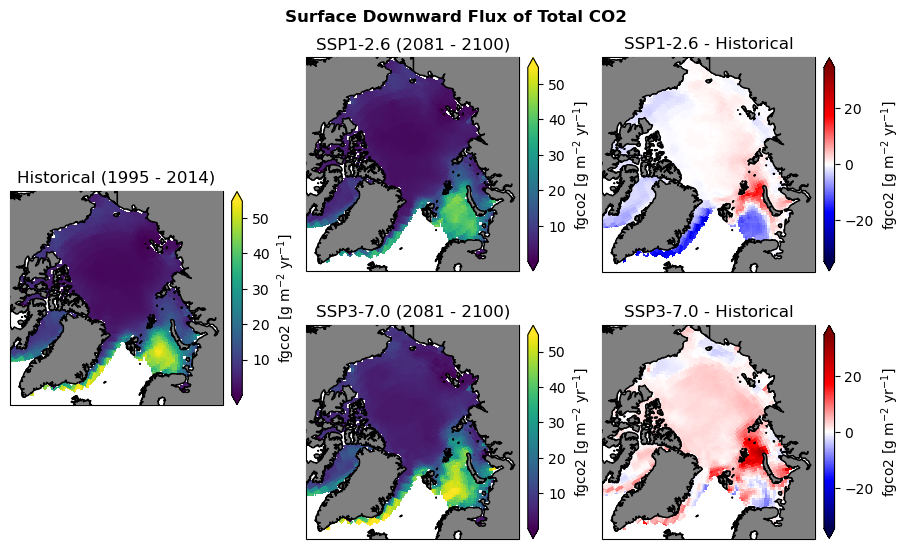

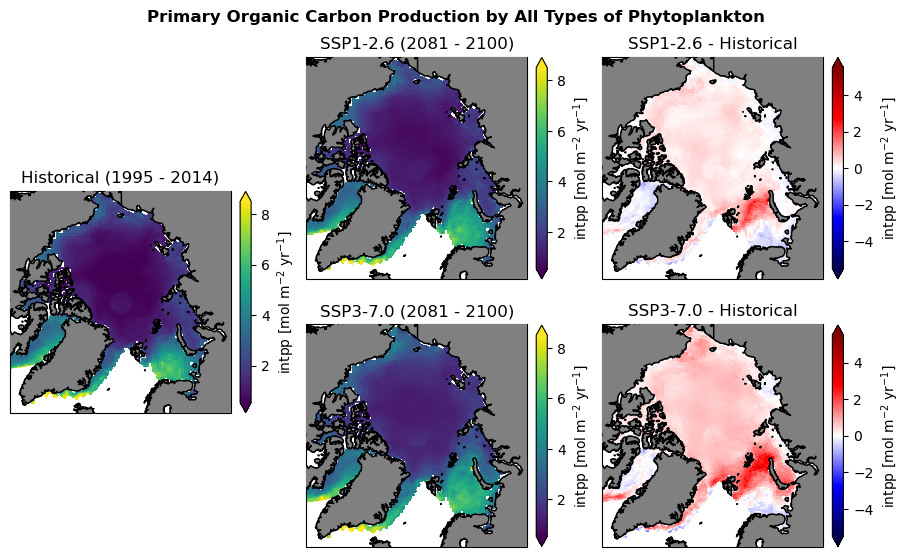

In [5]:
model = "MPI-ESM1-2-LR"
region = "masked"
variables = ["fgco2", "intpp", "intpoc", "intdic", "intdoc", "fric", "froc", "ocfriver", "cSoil", "cVeg", "fLuc", "gpp", "nbp", "nep", "npp", "ra", "rh"]
scenarios = ["ssp126", "ssp370"]

scenario_names = {"historical":"Historical", "ssp126":"SSP1-2.6", "ssp370":"SSP3-7.0"}

for variable in tqdm(variables[:2]):

    # Prepare the figure
    projection = ccrs.NorthPolarStereo()    
    fig = plt.figure(figsize=(9, 5.5), constrained_layout=True)#, tight_layout=True
    
    # Create a GridSpec with 3 rows and 3 columns
    gs = GridSpec(2, 3, figure=fig)
    
    # Add subplots
    ax1 = fig.add_subplot(gs[0:2, 0], projection=projection)  # large subplot on the left
    ax2 = fig.add_subplot(gs[0, 1], projection=projection)      # top-right
    ax3 = fig.add_subplot(gs[1, 1], projection=projection)#, sharex=ax2)      # middle-right
    ax4 = fig.add_subplot(gs[0, 2], projection=projection)#, sharey=ax2)      # bottom-middle
    ax5 = fig.add_subplot(gs[1, 2], projection=projection)#, sharex=ax4),sharey=ax3)      # bottom-right
    
    ax1.set_aspect(1)
    
    # Load data
    ds_hist = load_data(variable, model, region, "historical")
    
    if ds_hist[variable].attrs["units"] == 'kg m-2 yr-1':
        unit = "[g m$^{-2}$ yr$^{-1}$]"
        correction = 1000
    elif ds_hist[variable].attrs["units"] == 'kg m-2':
        unit = "[kg m$^{-2}$]"
        correction = 1
    elif ds_hist[variable].attrs["units"] == 'mol m-2 yr-1':
        unit = "[mol m$^{-2}$ yr$^{-1}$]"
        correction = 1
    else:
        unit = ds_hist[variable].attrs["units"]

    data_20_hist = calc_20_yr_mean(ds_hist, variable) * correction
    
    # Calculate differences
    Data = {}
    Diff = {}
    for scenario in scenarios:
        ds_ssp  = load_data(variable, model, region, scenario)
        data_20_ssp = calc_20_yr_mean(ds_ssp, variable) * correction
        Data[scenario] = data_20_ssp.values
        Diff[scenario] = data_20_ssp.values - data_20_hist
        ds_ssp.close()

    # Find vmin and vmax for the colorbar
    vmax = np.nanpercentile(np.array([data_20_hist, Data[scenarios[0]], Data[scenarios[1]]]),99)
    vmin = np.nanpercentile(np.array([data_20_hist, Data[scenarios[0]], Data[scenarios[1]]]),1)
    if variable in ["intdic", "cSoil", "ocfriver"]:
        percentile= 69
    elif variable == "ocfriver":
        percentile= 10
    else:
        percentile= 95
    vmax_diff = np.nanpercentile(abs(np.array([data_20_hist, Diff[scenarios[0]], Diff[scenarios[1]]])),percentile)
    #print(vmax_diff)

    # Plotting
    fig, ax1 = plot_map(ds_hist, data_20_hist, under=None, fig=fig, ax=ax1, vmax=vmax, vmin=vmin, cbar_label=f"{variable} {unit}")#
    
    axs = np.array([[ax2, ax4],[ax3, ax5]])
    for i, scenario in enumerate(scenarios):
        fig, ax = plot_map(ds_ssp, Data[scenario], under=None, fig=fig, ax=axs[i][0], vmax=vmax, vmin=vmin, cbar_label=f"{variable} {unit}")#, vmax=20, vmin=0
        diff = Data[scenario]-data_20_hist
        fig, ax = plot_map(ds_hist, diff, vmax=vmax_diff, vmin=-vmax_diff, cmap_str="seismic", fig=fig, ax=axs[i][1], cbar_label=f"{variable} {unit}")#
        axs[i][0].set_title(scenario_names[scenario] + " (2081 - 2100)")
        axs[i][1].set_title(scenario_names[scenario] + " - Historical")

    ax1.set_title("Historical (1995 - 2014)")
    fig.suptitle(ds_hist[variable].attrs["long_name"], fontweight="bold")
    #plt.savefig(f"/home/u/u301557/ArcticCarbon/plots/Maps/map_{model}_{region}_{variable}.png", dpi=200, bbox_inches='tight')
    #fig.show()